In [7]:
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)
# set color palette object
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

start = 2008
end = 2017

with pd.HDFStore('data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [8]:
sp500_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, MMM to ZTS
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               503 non-null    object
 1   gics_sector        503 non-null    object
 2   gics_sub_industry  503 non-null    object
 3   location           503 non-null    object
 4   first_added        493 non-null    object
 5   cik                503 non-null    int64 
 6   founded            503 non-null    object
dtypes: int64(1), object(6)
memory usage: 31.4+ KB


In [9]:
with pd.HDFStore('data/assets.h5') as store:
    prices = (store['quandl/wiki/prices'].adj_close.unstack('ticker')
              .filter(sp500_stocks.index).sample(n=30, axis=1))
prices.tail()

ticker,NWL,ADI,PNC,HON,EA,GD,EXPD,CSCO,TER,AXP,...,CZR,DVN,IDXX,CPRT,HST,SJM,CPB,WTW,AAP,MLM
date,,,,,,,,,,,,,,,,,,,,,
2018-03-21,26.81,92.80,158.89,151.36,126.00,223.75,64.06,44.31,49.50,94.74,...,12.200,32.92,200.23,51.25,18.75,120.16,42.17,65.70,115.24,206.74
2018-03-22,25.84,90.54,153.28,146.88,122.98,218.37,62.47,43.07,47.72,91.41,...,11.800,32.29,193.88,49.87,18.40,118.28,42.10,64.68,111.71,201.71
2018-03-23,25.35,87.70,147.24,143.28,121.44,218.81,60.88,42.42,45.65,90.45,...,11.250,32.23,190.31,49.73,17.98,118.76,42.27,63.06,110.84,205.68
2018-03-26,26.06,93.11,153.01,146.94,126.44,223.47,62.33,44.06,47.70,92.62,...,11.175,32.47,197.30,50.93,18.39,121.70,42.47,65.45,114.77,209.29
2018-03-27,25.19,91.05,149.18,144.34,119.98,221.07,61.63,42.68,45.76,91.42,...,11.000,31.71,190.90,49.99,18.33,122.41,42.69,62.50,115.01,205.43


In [10]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.tail(10)

ticker,NWL,ADI,PNC,HON,EA,GD,EXPD,CSCO,TER,AXP,...,KMX,DVN,IDXX,CPRT,HST,SJM,CPB,WTW,AAP,MLM
date,,,,,,,,,,,,,,,,,,,,,
2017-10-29,-0.009165,0.025638,0.008908,0.005848,0.028780,-0.041476,0.007637,0.005255,0.092815,0.040178,...,-0.010381,0.027197,0.022221,-0.016447,-0.001028,-0.004893,0.046987,-0.017174,-0.055888,0.004441
2017-11-05,-0.230750,0.006578,0.003402,-0.008413,-0.031568,-0.004537,-0.023918,0.001162,0.003276,0.006681,...,0.011162,0.094482,-0.076498,0.014771,0.009774,-0.014367,-0.034282,-0.011723,-0.001587,-0.024457
2017-11-12,-0.047774,-0.024180,-0.044432,0.005380,-0.003975,-0.021023,0.032787,-0.013925,0.019123,-0.030177,...,-0.033382,0.029030,-0.050228,-0.015380,0.018339,0.026331,0.020224,-0.008729,-0.007090,0.006799
2017-11-19,-0.025256,0.009264,0.002793,0.005077,-0.034856,-0.010012,-0.012030,0.056193,-0.002975,0.001818,...,-0.044441,-0.042811,0.048754,-0.008368,-0.005003,0.096715,0.048503,0.020095,0.099114,-0.025932
2017-11-26,-0.006653,-0.014046,-0.002183,0.021640,-0.008087,0.011276,0.012684,0.016435,0.001607,-0.002241,...,-0.020158,-0.016805,-0.000452,0.194374,-0.004525,-0.024696,-0.074014,-0.034307,-0.000448,-0.008762
2017-12-03,0.110680,-0.041952,0.063669,0.031672,-0.017788,0.013200,0.076653,0.030419,-0.079393,0.046855,...,0.004849,0.021299,0.001227,0.012953,-0.014646,0.038071,0.069070,-0.011002,0.112630,-0.015784
2017-12-10,-0.017455,0.001288,0.019858,-0.004793,-0.007074,-0.007748,-0.000155,0.000266,0.009973,0.007051,...,-0.013162,-0.020340,0.035935,0.022088,0.016914,0.025949,-0.005486,0.091773,0.010375,0.056501
2017-12-17,-0.011951,0.013681,0.007997,0.003840,0.038093,-0.011091,-0.000310,0.015421,0.033819,-0.000304,...,0.003705,-0.009724,-0.024724,0.002957,0.015121,0.006998,0.013075,-0.037572,0.003888,-0.045119
2017-12-24,0.002615,0.024916,0.008072,-0.004927,-0.029832,0.019111,0.005121,0.009427,0.021729,0.002233,...,-0.036911,0.103238,0.006705,-0.016784,0.000000,0.048392,-0.016536,0.114248,-0.001490,0.032577


In [11]:
stocks = weekly_returns.columns
n_obs, n_assets = weekly_returns.shape
n_obs, n_assets

(521, 29)

In [12]:
# total simulation cnt
NUM_PF = 100000

# create uniform distribution with n_assets #s btw 0 & 1
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

# annualization factor based on weekly_returns
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

In [17]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()
# numpy.linalg.inv() : inverse matrix
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)
precision_matrix

ticker,NWL,ADI,PNC,HON,EA,GD,EXPD,CSCO,TER,AXP,...,KMX,DVN,IDXX,CPRT,HST,SJM,CPB,WTW,AAP,MLM
ticker,,,,,,,,,,,,,,,,,,,,,
NWL,755.238495,80.861747,82.819002,-82.969783,-46.784282,48.236511,-95.326058,-94.499138,-150.767248,-33.926374,...,-56.167342,-32.775925,-35.988539,58.344445,-10.071819,-46.781577,-60.166303,-22.252516,-47.033236,-32.021913
ADI,80.861747,1687.831857,46.988759,-48.509936,-73.591644,-21.085682,-73.920612,-94.318230,-339.027633,-40.412491,...,-67.954674,-75.696922,36.079395,-5.712470,103.711454,83.516445,-218.689023,-35.849884,-115.228933,-17.632949
PNC,82.819002,46.988759,1081.454117,-146.921460,-47.159170,-1.122530,107.695300,38.094944,-48.225427,-213.689785,...,-111.590074,47.203570,-43.895460,-2.185130,-151.556062,211.702469,-21.530479,0.038686,105.882875,-91.306796
HON,-82.969783,-48.509936,-146.921460,3189.793145,69.784775,-997.879229,-75.739376,-100.372134,-220.570817,-152.620175,...,38.104536,-158.784675,-113.259428,-197.202555,-151.078577,-174.768184,-196.271478,-41.492032,89.148780,-115.571263
EA,-46.784282,-73.591644,-47.159170,69.784775,547.160097,-2.768748,-44.197764,-72.166305,-74.537812,19.175197,...,5.013520,12.346804,12.536385,-33.394393,1.177527,-37.856508,-50.494054,-3.749116,10.027131,2.849097
GD,48.236511,-21.085682,-1.122530,-997.879229,-2.768748,2311.861552,-114.162106,-198.621004,-76.394277,-49.668725,...,-119.773946,-67.938450,-87.112513,-72.153405,-24.086872,-18.156441,-218.851149,-13.584039,-3.850033,112.650977
EXPD,-95.326058,-73.920612,107.695300,-75.739376,-44.197764,-114.162106,1419.489793,-140.126301,4.901009,-107.626565,...,-29.566385,12.127907,-18.881662,-18.001587,-92.389416,-27.965447,10.537791,6.210035,-58.990295,-55.704843
CSCO,-94.499138,-94.318230,38.094944,-100.372134,-72.166305,-198.621004,-140.126301,1395.710242,-128.374970,9.397128,...,34.131920,-33.178345,-65.720554,-55.387813,-11.533361,0.191905,-95.550585,-11.110766,29.483702,-60.898926
TER,-150.767248,-339.027633,-48.225427,-220.570817,-74.537812,-76.394277,4.901009,-128.374970,959.525356,-30.001701,...,-66.987550,20.978517,-9.654551,49.703666,-39.797756,-5.262534,119.232794,-3.179905,3.758706,-13.749703


In [18]:
# get FRED data(10y t-bill) from pandas_datareader for rf rate
treasury_10yr_monthly = (
    web.DataReader('DGS10', 'fred', start, end).resample('M').last().div(periods_per_year).div(100).squeeze())
rf_rate = treasury_10yr_monthly.mean()
# risk-free rate of the mean of monthly 10y treasury rate
rf_rate

0.0004989138176638178

In [19]:
web.DataReader('DGS10', 'fred', '2021', '2024').tail(10)

,DGS10
DATE,
2023-03-17,3.39
2023-03-20,3.47
2023-03-21,3.59
2023-03-22,3.48
2023-03-23,3.38
2023-03-24,3.38
2023-03-27,3.53
2023-03-28,3.55
2023-03-29,3.57


In [20]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    # dirichlet(parametric distribution) - continuous random variables vector of k-dimension, bigger than zero and total sum = 1 & 'can be used to consisting PF weights randomly'
    # dirichlet expresses the distribution over distributions
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)
    # weights.dot(mean_ret.values + 1) = weights @ mean_ret.values + 1
    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)
df = pd.DataFrame(simul_wt)
# df.describe()
simul_perf.head()

,Annualized Standard Deviation,Annualized Returns,Sharpe Ratio
0,0.302071,0.062243,0.204401
1,0.245360,0.158352,0.643353
2,0.220278,0.247054,1.119292
3,0.206274,0.112582,0.543369
4,0.227628,0.175847,0.770328


Max Sharpe: 20.63%, 33.27%
Min Volatility : 14.99%, 17.54%


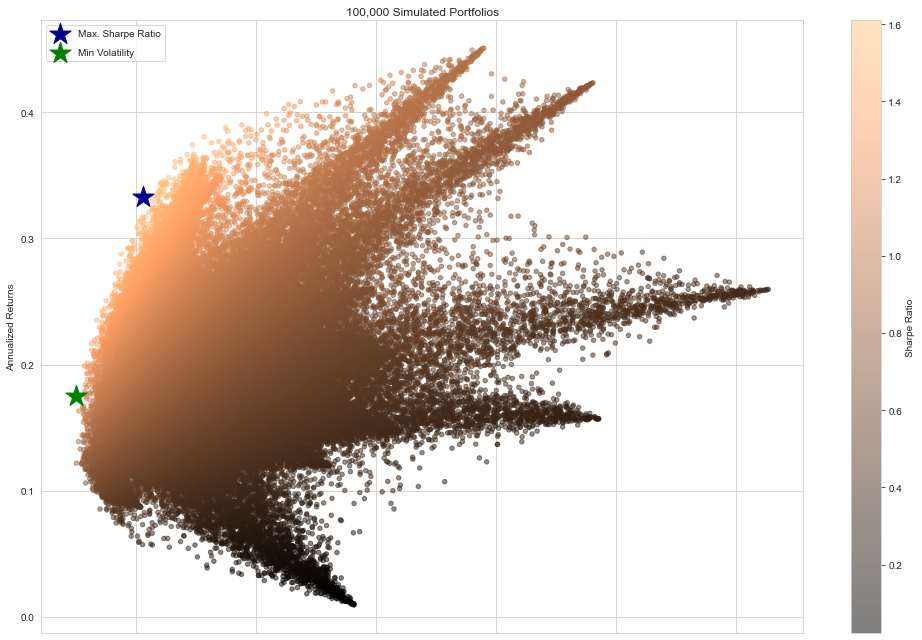

In [21]:
# Plot 100,000 simulated PFs
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='copper', alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
print(f'Min Volatility : {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

In [22]:
# Annualized PF standard deviation
def portfolio_std(wt, rt=None, cov=None):
    return np.sqrt(wt @ cov @ wt * periods_per_year)

# Annualized PF returns
def portfolio_returns(wt, rt=None, cov=None):
    return (wt @ rt + 1) ** periods_per_year - 1

# Annualized PF returns & standard deviation
def portfolio_performance(wt, rt, cov):
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

# negative Sharp Ratio for scipy's minimize function for optimization
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x))-1}

def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio, # object function(UDF)
                    x0=x0, # initial value
                    args=(mean_ret, cov), # parameters for object function except for initial value
                    method='SLSQP', # optimal solution method
                    bounds=((-1 if short else 0, 1),) * n_assets, # threshold
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

In [23]:
# Compute efficient frontier
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq', 'fun': lambda x: ret_(x) - target}, weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

# min volatility PF
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

In [26]:
# get random PF
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)
simul_perf.describe()

,Annualized Standard Deviation,Annualized Returns,Sharpe Ratio
count,100000.000000,100000.000000,100000.000000
mean,0.276794,0.193377,0.722606
std,0.074725,0.061609,0.231172
min,0.147496,0.008774,0.021609
25%,0.226217,0.153696,0.565851
50%,0.258480,0.183246,0.711566
75%,0.310191,0.223038,0.849654
max,0.726282,0.450492,1.591647


In [27]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.228568
Annualized Returns               0.364299
Sharpe Ratio                     1.591647
Name: 10549, dtype: float64

In [28]:
# Get Max Sharpe PF
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.336779
sd     0.205685
sr     1.634930
dtype: float64

In [29]:
# Get Min Volatility PF
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)
min_vol_perf

(0.1586594613431389, 0.14095162045293536)

In [30]:
# Get Efficient PFs
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))
eff_pf.tail()

0.341597    0.414433
0.374690    0.423448
0.409284    0.432463
0.444979    0.441477
0.485634    0.450492
dtype: float64

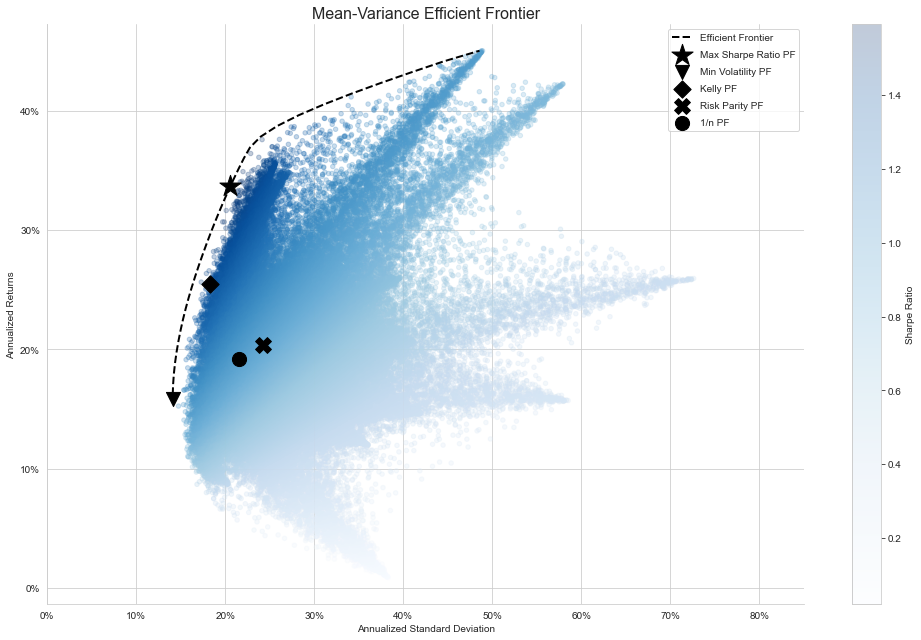

In [31]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25,
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k', label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')

ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();